## Step 1: Overview

* What is the task in terms of CV? 

Our task is semantic segmentation. This means we are creating a model to assign each pixel in a given input image to one class.

* What data are you using. (2-3 lines)

We are using satellite image data of atolls, primarily from French Polynesia. We received this in multiple different formats, and chose to use NIR images in order to most easily distinguish between various classes. 

* Describe your class labels/annotations used in this notebook.

We split these images into three class labels: First, Vegetation, referring to any dry land containing vegetation and showing up as bright red on the NIR images. Second, Reef Flats, referring to areas which are sandy or shallow water. Finally, Ocean refers to everything else, the background water of the image.

* Mention what annotation tool you used.

We primarily used Dashdoodler in our initial annotations of the data. However, we have found that the provided annotations created using K-Means clustering gives overall better results, so this model uses those annotations.

* Describe the process of the best model below.

## Step 2: Import the libraries 

In [ ]:

#imports and dependencies
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## Step 2: Prepare your data

* Mount your data from google drive to co-lab (feel free to use your team's folder to upload data)
* load, preprocess, normalize, one hot encoding/scaling, split data for the model

In [ ]:
#mount drive and set up directories

from google.colab import drive

drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In order for data loading to work, one must make a shortcut to this folder in their drive. This can be done as follows:

1. navigate to our team's folder, AiZoom
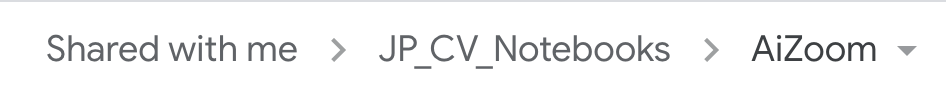

2. Open the dropdown menu and click "Add shortcut to Drive" 

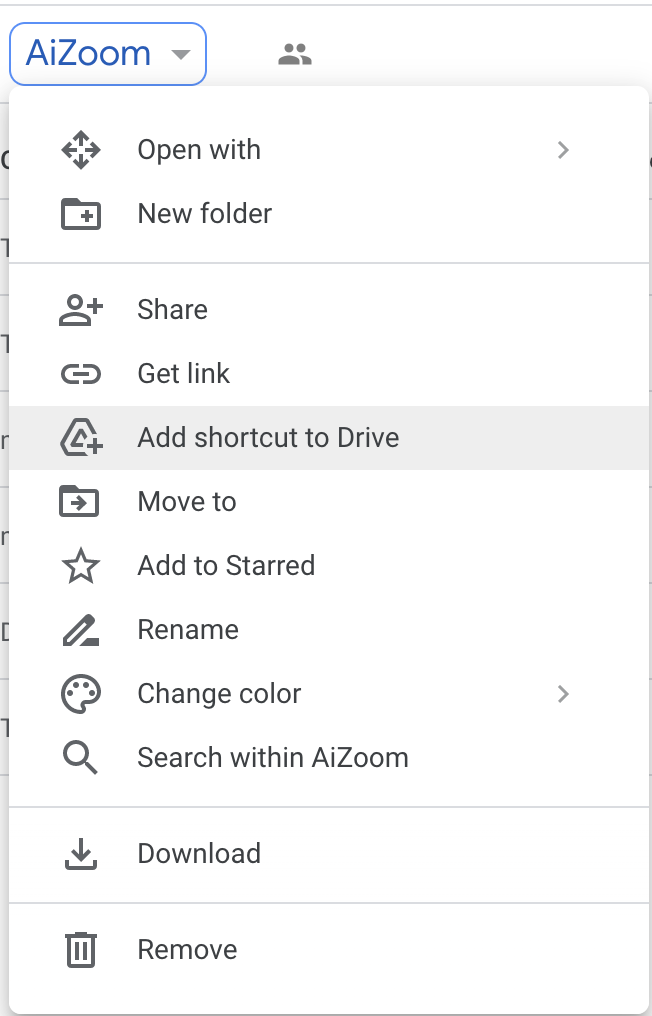

This step is necessary because items that are shared can not be accessed from just mounting the drive.

In [ ]:
#Resizing images, if needed
SIZE_X = 224 
SIZE_Y = 224
n_classes=3 #Number of classes for segmentation


In [ ]:
#rounding to be utilized later
def custom_round(x, base=5):
    return int(base * round(float(x)/base))


In [ ]:
#Capture mask/label info as a list


train_masks = [] 
train_images = []

#need to sort and make list of names 
# then match to training images
#then save masks and training images to matching indexes of image and ground truth arrs
mask_path = "/content/drive/MyDrive/AiZoom/JPG_Labeled/"
im_path = "/content/drive/MyDrive/AiZoom/NIR/"
                               
#sort masks by name
maskDisO = os.listdir(mask_path)
maskNames = sorted(maskDisO)
#sort imgs by name 
imDisO = os.listdir(im_path)
imNames = sorted(imDisO)
#now need to do name matching
#will take a mask, and check if imNames has any files with corresponding names
#if it does contain a match, save mask to train_masks, and image to train_images


for mask in maskNames: 
  for im in imNames:
    #look through each image for each mask
    if mask[:-6] in im and mask.endswith("l8.jpg"):#checks for substring match (image name)
      maskArr = cv2.imread(mask_path+mask)
      imArr = cv2.imread(im_path+im)
      #resize images
      maskArr = cv2.resize(maskArr,(SIZE_X,SIZE_Y), interpolation = cv2.INTER_CUBIC)
      imArr = cv2.resize(imArr,(SIZE_X,SIZE_Y), interpolation = cv2.INTER_CUBIC)
      #append to mask and image lists
      train_masks.append(maskArr)
      train_images.append(imArr)


#Convert lists to array      
train_masks = np.array(train_masks)
print(str(train_masks.shape)+"\n"+str(train_masks.size))
train_images = np.array(train_images)
print(str(train_images.shape)+"\n"+str(train_images.size))

normalRGBtrain = [] #mask images resized
RGBorig = [] #images resized
for imgIdx in range(train_images.shape[0]):
  #for each img index
  img = train_images[imgIdx]
  #convert color since cv2 uses BGR and we want RGB
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  #rotate for data augmentation 
  rotate = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
  twoRotate = cv2.rotate(rotate, cv2.ROTATE_90_CLOCKWISE)
  threeRotate = cv2.rotate(twoRotate, cv2.ROTATE_90_CLOCKWISE)
  #append augmented data
  RGBorig.append(img)
  RGBorig.append(rotate)
  RGBorig.append(twoRotate)
  RGBorig.append(threeRotate) 

#convert to array again
train_images = np.array(RGBorig)

for imgIdx in range(train_masks.shape[0]):
  #for each mask
  #grayscale
  img = cv2.cvtColor(train_masks[imgIdx], cv2.COLOR_BGR2GRAY)
  #threshold to isolate ocean pixels
  ret,ocean = cv2.threshold(img,50,255,cv2.THRESH_BINARY_INV)
  #threshold to isolate reef pixels
  ret,reef = cv2.threshold(img,200,255,cv2.THRESH_BINARY)
  #threshold to isolate land and reef pixels
  ret,reefLand = cv2.threshold(img,50,255,cv2.THRESH_BINARY)
  #subtracting reef from reef and land gives us land
  land = reefLand - reef
  #new list for JUST this image
  label = []
  #add reef as its own channel
  label.append(reef)
  #add land as its own channel
  label.append(land)
  #add ocean as its own channel
  label.append(ocean)
  #convert list to array, makes this a new image!
  label = np.array(label)
  #now need to match input and switch axes around
  label = np.swapaxes(label, 0,1)
  label = np.swapaxes(label, 1,2)
  #normalize values of label
  label = label/255
  #data augmentation
  rotate = cv2.rotate(label, cv2.ROTATE_90_CLOCKWISE)
  maskTwoRotate = cv2.rotate(rotate, cv2.ROTATE_90_CLOCKWISE)
  maskThreeRotate = cv2.rotate(maskTwoRotate, cv2.ROTATE_90_CLOCKWISE)

  #append in same order as above so indices correspond to a mask, image pair
  normalRGBtrain.append(label)
  normalRGBtrain.append(rotate)
  normalRGBtrain.append(maskTwoRotate)
  normalRGBtrain.append(maskThreeRotate)


#make array with all of our new arrays
train_masks = np.array(normalRGBtrain)

#checks that maskset and imageset are same size 
print(train_masks.shape)
print(train_images.shape)

(144, 224, 224, 3)
21676032
(144, 224, 224, 3)
21676032
(576, 224, 224, 3)
(576, 224, 224, 3)


In [ ]:
#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split

#here need to split data and order in a way that makes index in array correspond to particular image-mask pair
X1, X_test, y1, y_test = train_test_split(train_images, train_masks, test_size = 0.10, random_state = 0)

#Further split training data to a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

from keras.utils import to_categorical

## Step 3: Model

In [ ]:
#let's set up the structure of our model:
def multi_unet_model(n_classes=3, IMG_HEIGHT=448, IMG_WIDTH=448, IMG_CHANNELS=3):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255)(inputs)   #Normalize images before input

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    print(c4.shape)
    c4 = Dropout(0.2)(c4)
    print(c4.shape)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    print(c4.shape)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model#, c9 to get features 

In [ ]:
##prep evaluation metrics

#obtained from: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
#users TQA and Tasos

from keras import backend as K

def recall_m(y_true, y_pred):
    """
      calculate recall manually
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    """
    calculate precision manually
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    """
    calculate f1 score manually

    Uses precision_m() and recall_m() defined above
    """
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


## Step 4: Training

In [ ]:
###############################################################
from sklearn.utils import class_weight

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
  #returns model 
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
#compile and define loss function and metrics for real time evaluation
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1_m])
model.summary()

#If starting with pre-trained weights, load here.

#model.load_weights('/content/drive/MyDrive/Coral_Reef_Metadata/aiZoom-atolls-w-kmeans-8.hdf5')

#train model with desired hyperparameters
history = model.fit(X_train, y_train, 
                    batch_size = 4, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)
#path to save weights           
weights_path = '/content/drive/MyDrive/AiZoom/aiZoom-atolls-w-kmeans-8.hdf5'
#save weights to defined path
model.save(weights_path)

(None, 28, 28, 128)
(None, 28, 28, 128)
(None, 28, 28, 128)
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_11 (Lambda)             (None, 224, 224, 3)  0           ['input_12[0][0]']               
                                                                                                  
 conv2d_209 (Conv2D)            (None, 224, 224, 16  448         ['lambda_11[0][0]']              
                                )                                                                 
                               

## Step 5: Evaluate

In [ ]:
#initial evaluation
#Evaluate the model
%time
#also gives us info on time per image
print(model.evaluate(X_test, y_test))
_, f1 = model.evaluate(X_test, y_test)
print("F1 is = ", (f1 * 100.0), "%")

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10 µs
2/2 [==============================] - 0s 76ms/step - loss: 0.0451 - f1_m: 0.9822
[0.04512898623943329, 0.9821748733520508]
2/2 [==============================] - 0s 64ms/step - loss: 0.0451 - f1_m: 0.9822
F1 is =  98.21748733520508 %


In [ ]:
##################################
#uncomment if one wants to load different set of weights 
# model = get_model()
# model.load_weights(weights_path) 



#make prediction that we can look at later
%time #confirms metrics above
y_pred=model.predict(X_test)
print(y_pred.shape)
y_pred_argmax=np.argmax(y_pred, axis=3)
print(y_pred_argmax.shape)

##################################################

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.58 µs
2/2 [==============================] - 0s 117ms/step
(58, 224, 224, 3)
(58, 224, 224)


In [ ]:
##################################################
#Using built in keras function to compute IoU
from keras.metrics import MeanIoU
n_classes = 3
testIndex = 3
IOU_keras = MeanIoU(num_classes=n_classes)  
#calc IoU for veg
iou1 = IOU_keras.update_state(y_test[:,:,:,0], np.around(y_pred[:,:,:,0],decimals=0))
print("vegetation IoU: " + str(IOU_keras.result().numpy()))
res1 = IOU_keras.result().numpy()
#calc IoU for reef
iou2 = IOU_keras.update_state(y_test[:,:,:,1], np.around(y_pred[:,:,:,1],decimals=0))
print("reef flat IoU: " + str(IOU_keras.result().numpy()))
res2 = IOU_keras.result().numpy()
#calc IoU for ocean
iou3 = IOU_keras.update_state(y_test[:,:,:,2], np.around(y_pred[:,:,:,2],decimals=0))
print("ocean IoU: " + str(IOU_keras.result().numpy()))
res3 = IOU_keras.result().numpy()
# take mean to find mean IoU
print("Mean IoU: " + str((res1+res2+res3)/3))
#######################################################################

vegetation IoU: 0.9260583
reef flat IoU: 0.9212005
ocean IoU: 0.9738322
Mean IoU: 0.9403636455535889


In [ ]:
#evaluate other metric for accuracy
#https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

# evaluate the model f1, precision, recall
#compile model with our new metrics
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])
#evaluate model and assign to variables
loss, accuracy, f1_score, precision, recall = model.evaluate(y_test, y_pred, verbose=0)
#print the metrics that we care about
print("f1: ",f1_score, ", precision: ", precision, " , recall: ", recall)

f1:  0.8560752868652344 , precision:  0.8560173511505127  , recall:  0.8561334013938904


Let's look at some predictions visually:

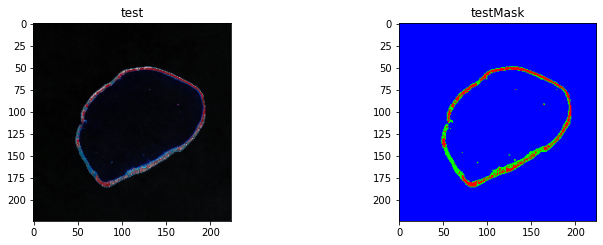

1/1 [==============================] - 0s 230ms/step


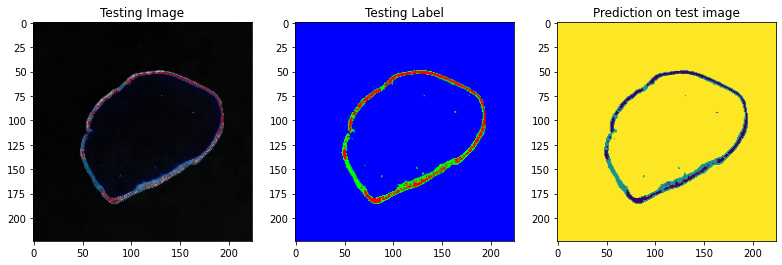

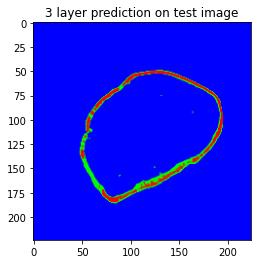

In [ ]:
import random
#pull random image to examine
#get random index
test_img_number = random.randint(0, len(X_test)-1)
#get img
test_img = X_test[test_img_number]
#and its respective mask
ground_truth=y_test[test_img_number]
#normalize image
test_img_norm=test_img[:,:,0][:,:,None]
test = np.squeeze(test_img)
#make figure
plt.figure(figsize=(12, 8))
plt.subplot(221)
#show image
plt.title('test')
imgplot = plt.imshow(test,cmap='viridis')
plt.subplot(222)
#and its mask
plt.title('testMask')
imgplot = plt.imshow(255*np.squeeze(ground_truth),cmap='viridis')
plt.show()
four_dim = np.expand_dims(test_img, axis = 0)

#now make prediction
prediction = (model.predict(four_dim))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

#make new figure to show prediction
plt.figure(figsize=(18, 20))
plt.subplot(241)
#image
plt.title('Testing Image')
plt.imshow(test_img.astype(np.uint8), cmap='viridis')
plt.subplot(242)
#label
plt.title('Testing Label')
plt.imshow((255*ground_truth).astype(np.uint8), cmap='viridis')
plt.subplot(243)
#prediction
plt.title('Prediction on test image')
plt.imshow(predicted_img.astype(np.uint8), cmap='viridis')
plt.show()
#three layer prediction (helpful for seeing where model isn't quite sure as it will be blurrier)
plt.title('3 layer prediction on test image')
plt.imshow(prediction[0,:,:,:].astype(np.uint8), cmap='viridis')
plt.show()

#####################################################################

Now let's see our predictions on our entire test set

1/1 [==============================] - 0s 20ms/step


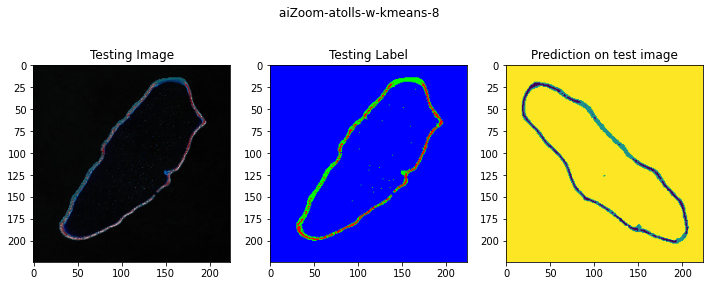

1/1 [==============================] - 0s 21ms/step


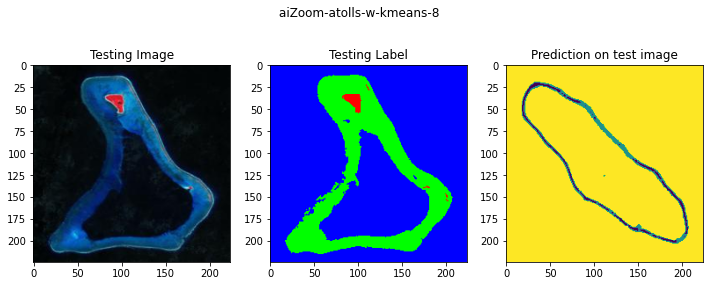

1/1 [==============================] - 0s 18ms/step


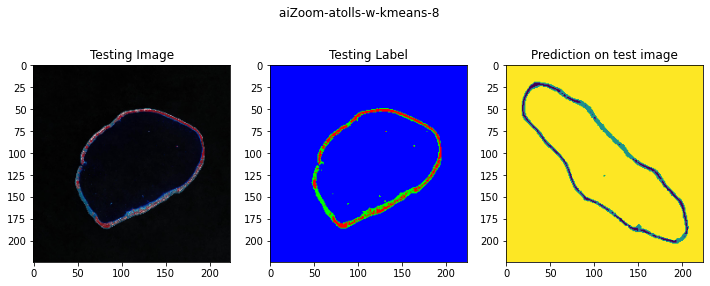

1/1 [==============================] - 0s 19ms/step


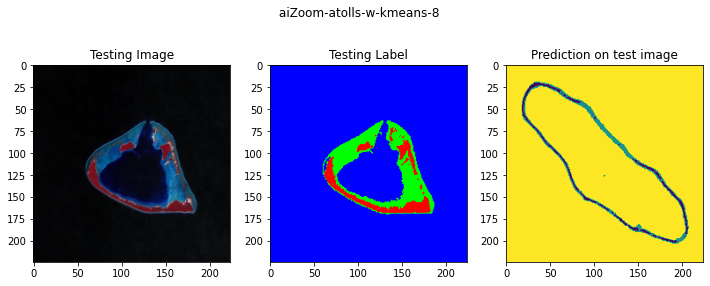

1/1 [==============================] - 0s 17ms/step


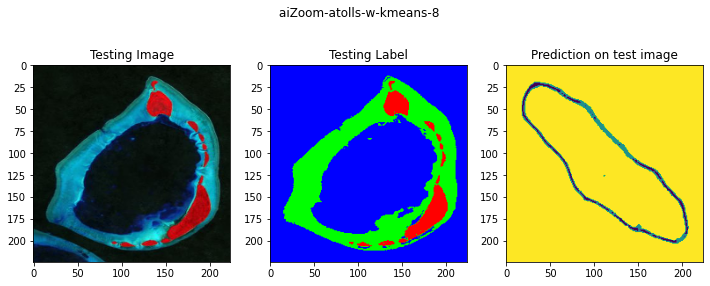

1/1 [==============================] - 0s 17ms/step


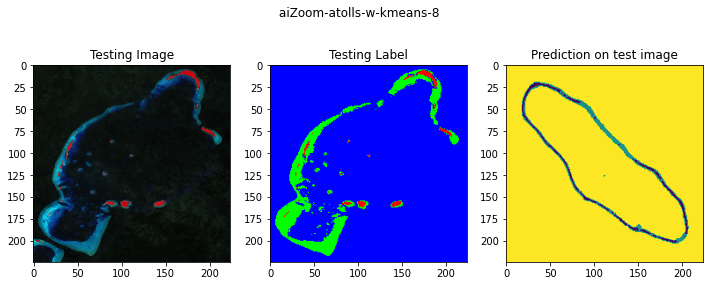

1/1 [==============================] - 0s 24ms/step


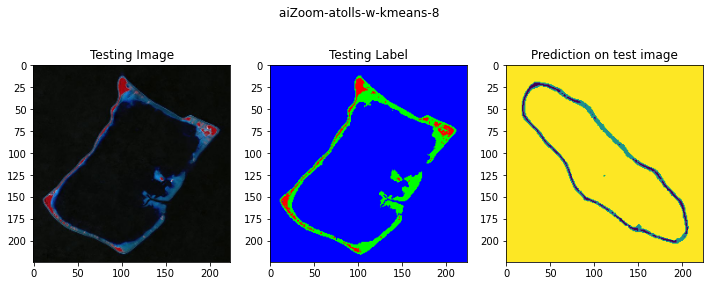

1/1 [==============================] - 0s 17ms/step


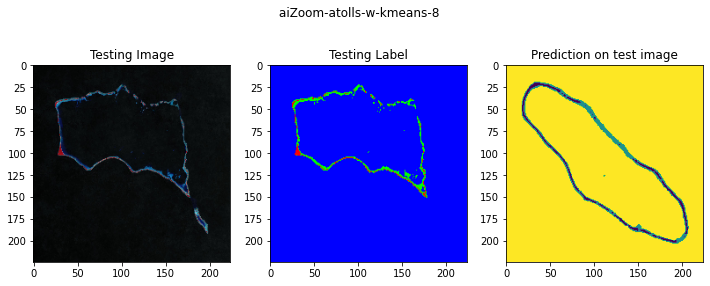

1/1 [==============================] - 0s 19ms/step


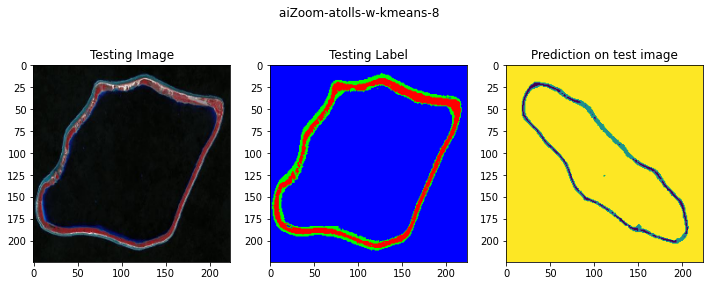

1/1 [==============================] - 0s 54ms/step


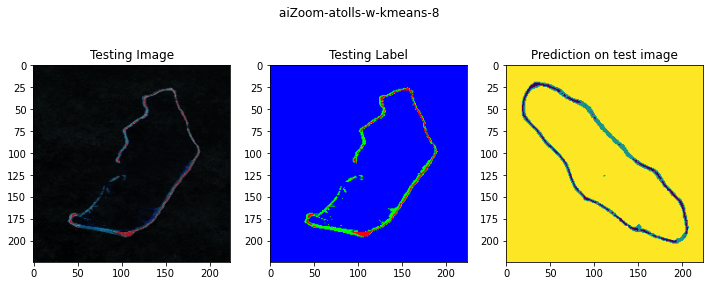

1/1 [==============================] - 0s 17ms/step


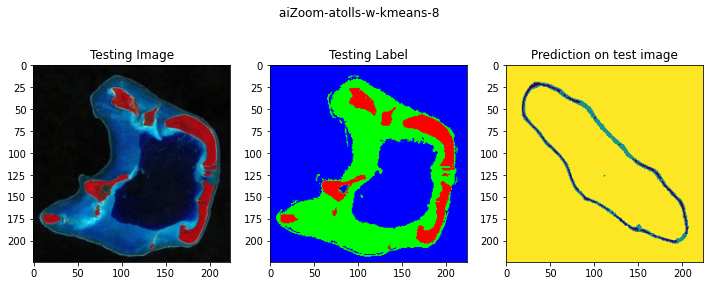

1/1 [==============================] - 0s 22ms/step


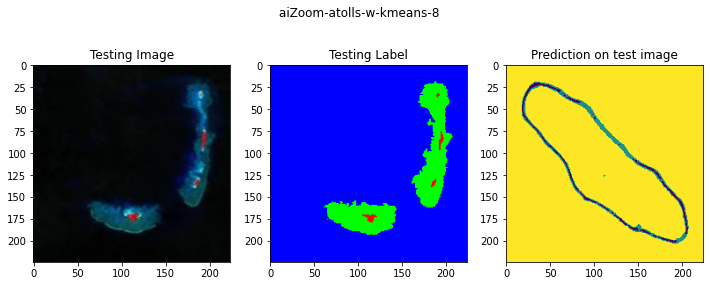

1/1 [==============================] - 0s 18ms/step


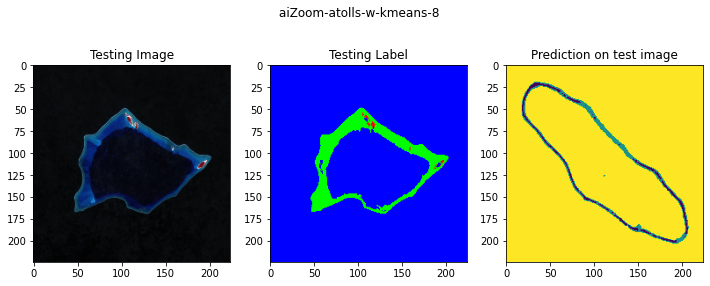

1/1 [==============================] - 0s 17ms/step


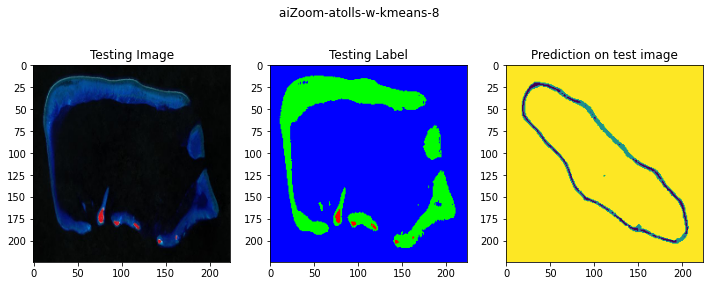

1/1 [==============================] - 0s 21ms/step


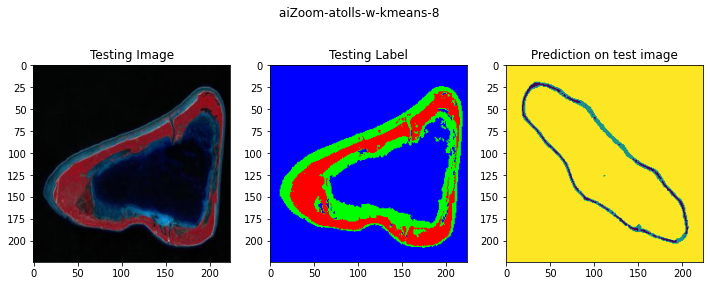

1/1 [==============================] - 0s 22ms/step


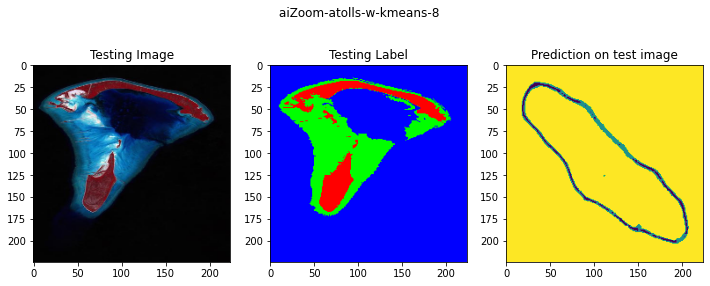

1/1 [==============================] - 0s 21ms/step


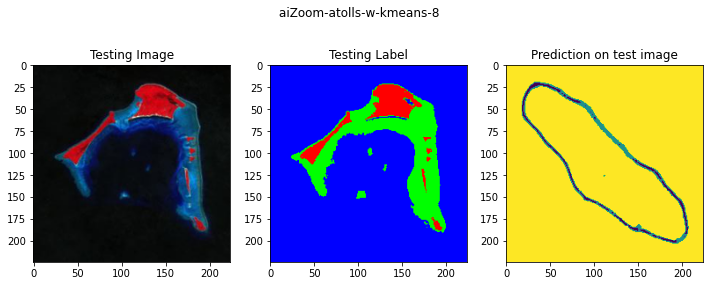

1/1 [==============================] - 0s 18ms/step


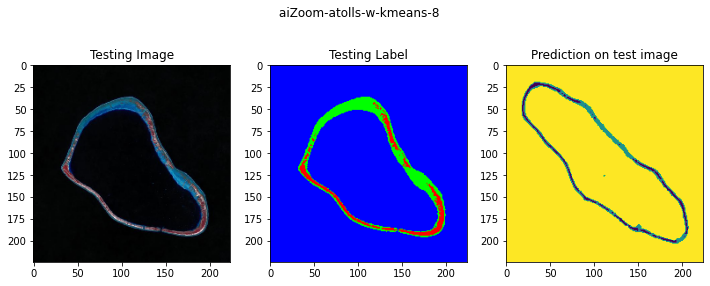

1/1 [==============================] - 0s 24ms/step


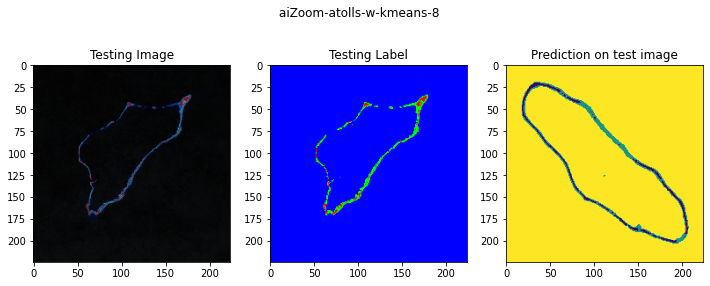

1/1 [==============================] - 0s 24ms/step


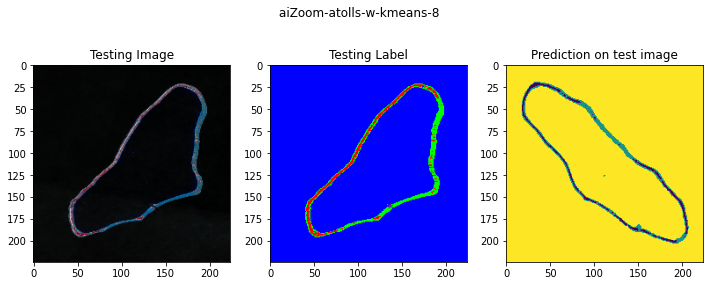

1/1 [==============================] - 0s 19ms/step


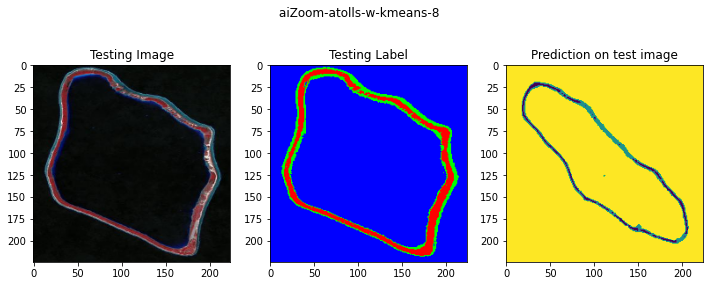

1/1 [==============================] - 0s 28ms/step


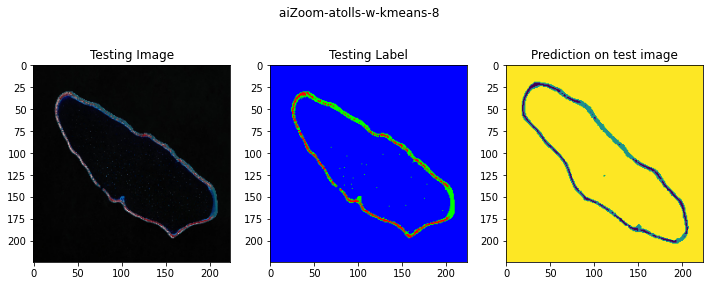

1/1 [==============================] - 0s 28ms/step


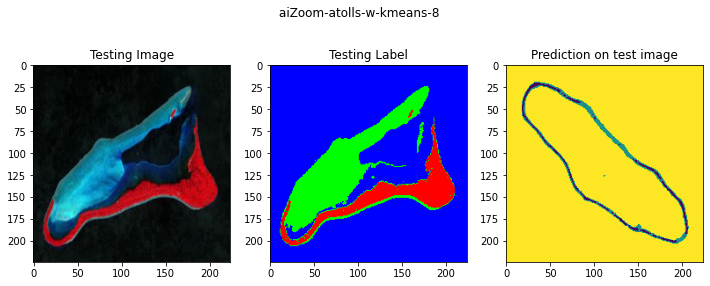

1/1 [==============================] - 0s 27ms/step


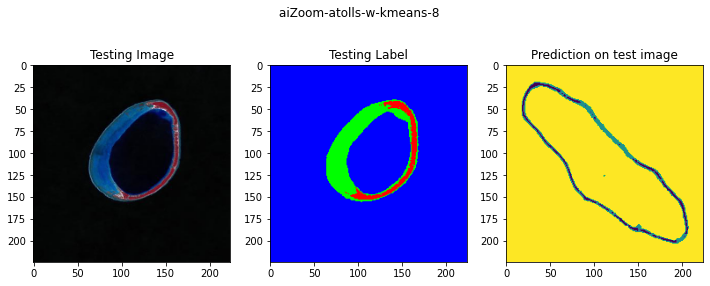

1/1 [==============================] - 0s 21ms/step


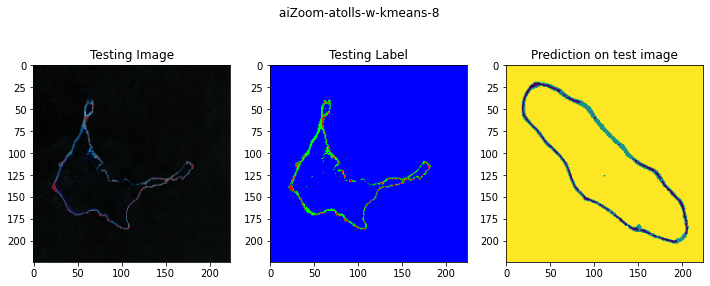

1/1 [==============================] - 0s 22ms/step


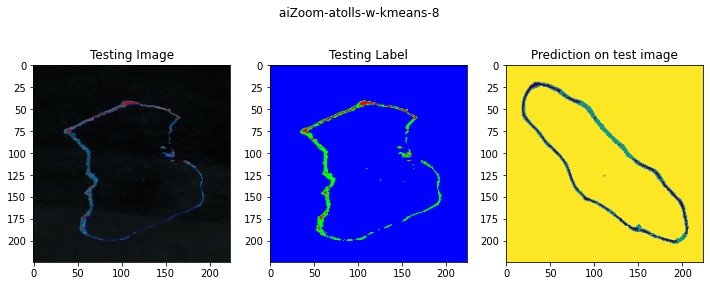

1/1 [==============================] - 0s 26ms/step


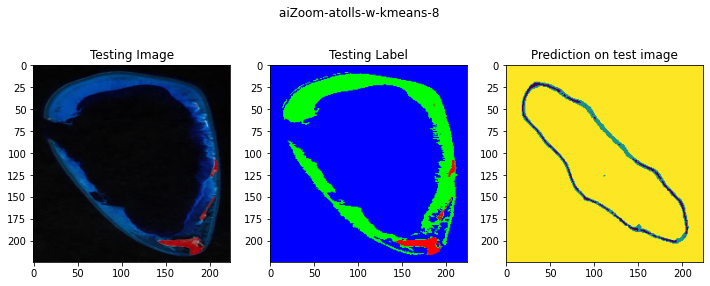

1/1 [==============================] - 0s 29ms/step


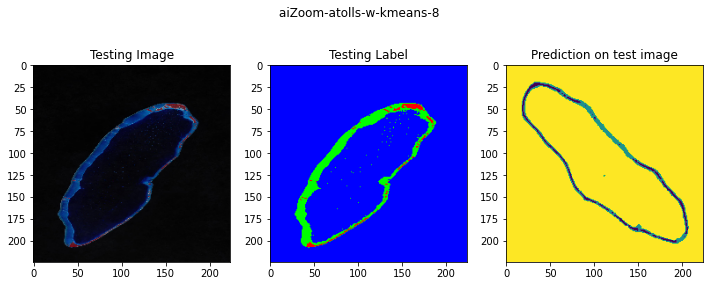

1/1 [==============================] - 0s 27ms/step


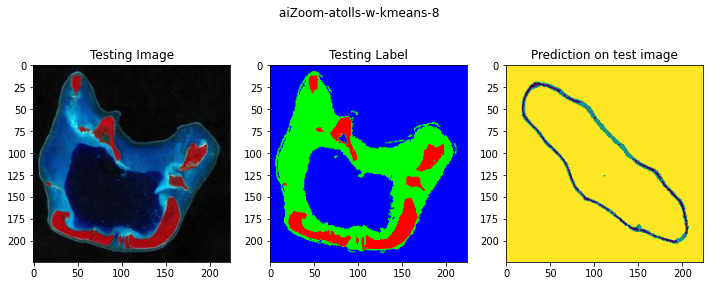

1/1 [==============================] - 0s 26ms/step


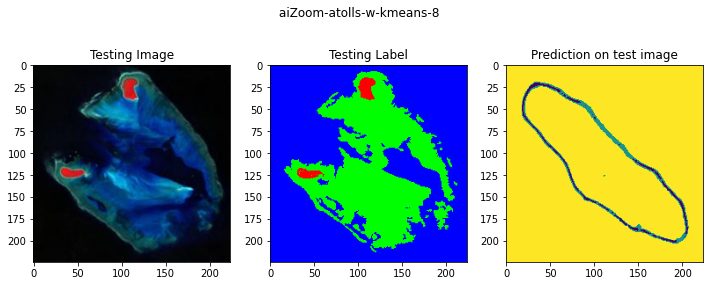

1/1 [==============================] - 0s 25ms/step


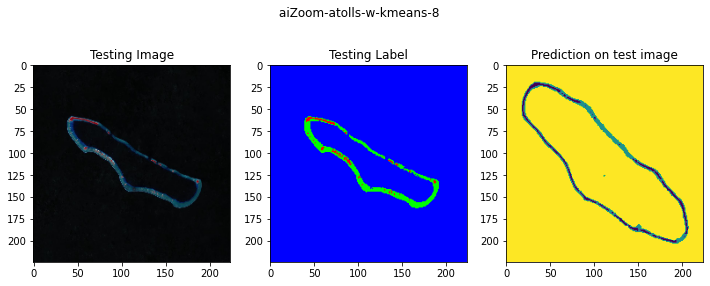

1/1 [==============================] - 0s 27ms/step


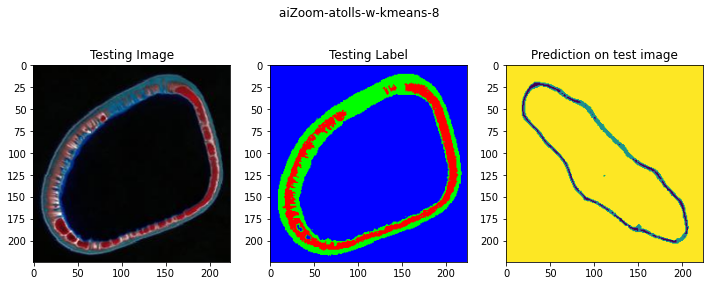

1/1 [==============================] - 0s 37ms/step


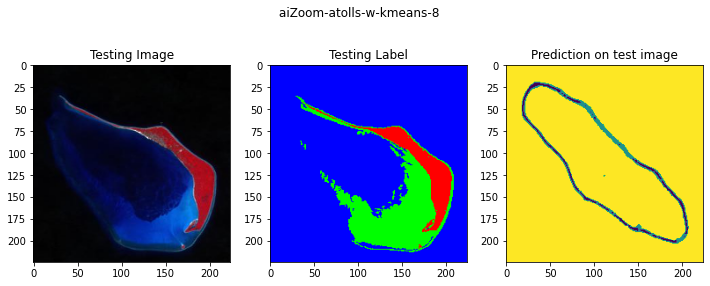

1/1 [==============================] - 0s 23ms/step


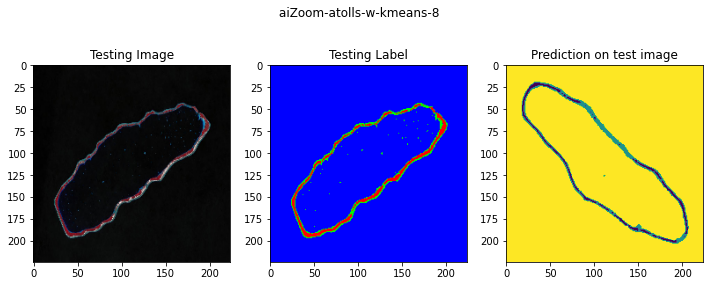

1/1 [==============================] - 0s 23ms/step


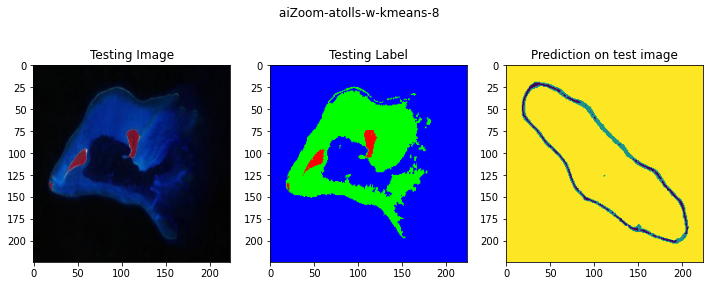

1/1 [==============================] - 0s 32ms/step


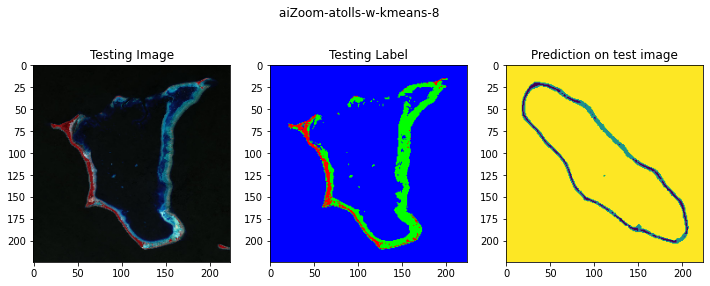

1/1 [==============================] - 0s 36ms/step


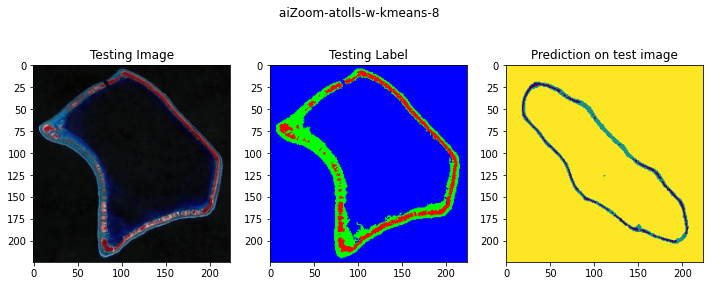

1/1 [==============================] - 0s 36ms/step


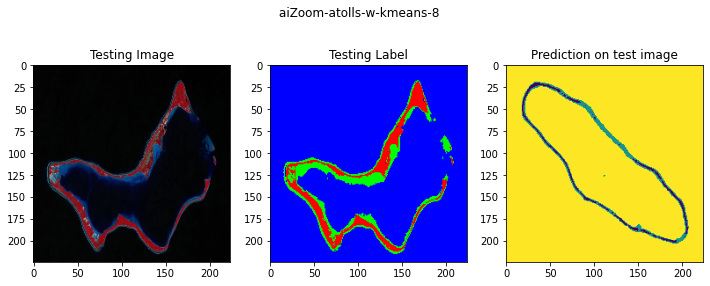

1/1 [==============================] - 0s 35ms/step


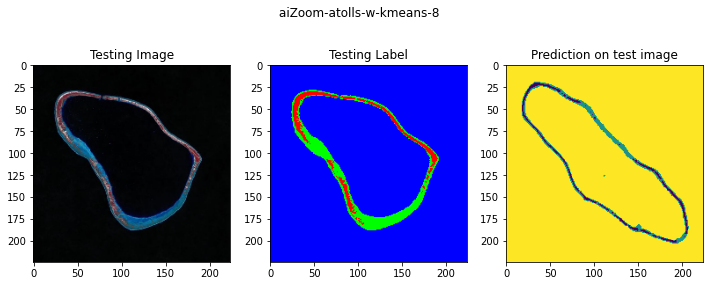

1/1 [==============================] - 0s 23ms/step


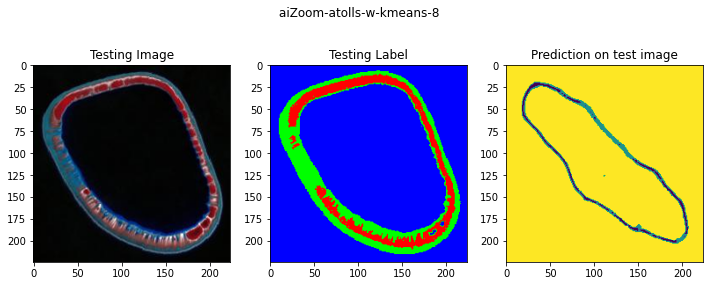

1/1 [==============================] - 0s 24ms/step


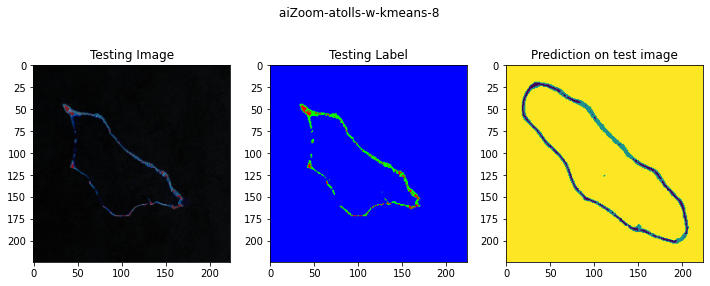

1/1 [==============================] - 0s 30ms/step


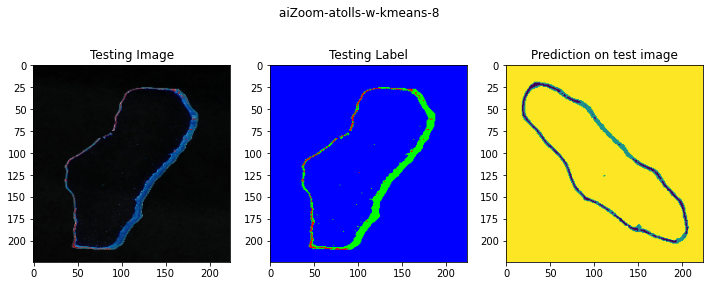

1/1 [==============================] - 0s 23ms/step


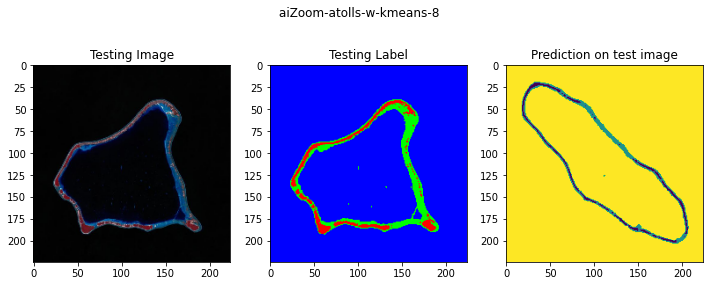

1/1 [==============================] - 0s 26ms/step


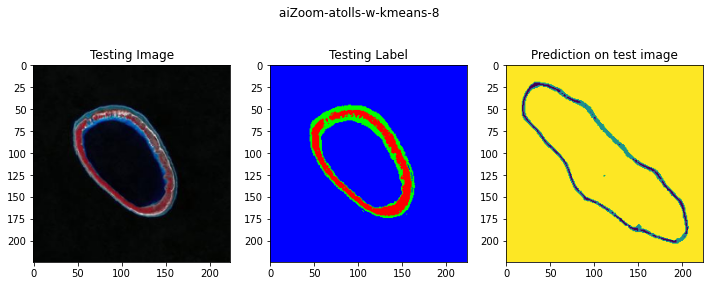

1/1 [==============================] - 0s 27ms/step


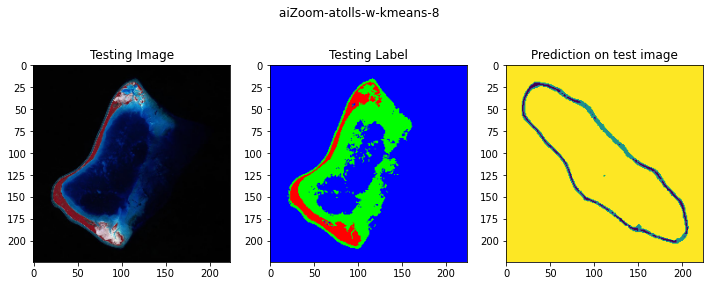

1/1 [==============================] - 0s 25ms/step


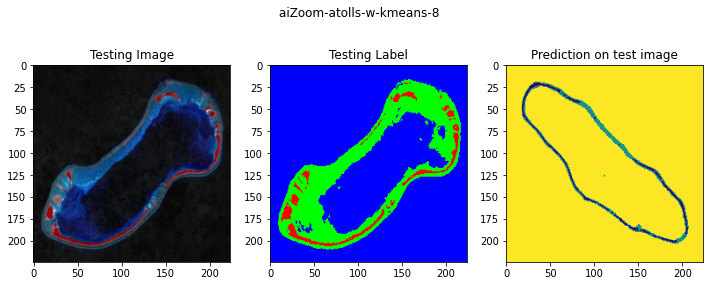

1/1 [==============================] - 0s 34ms/step


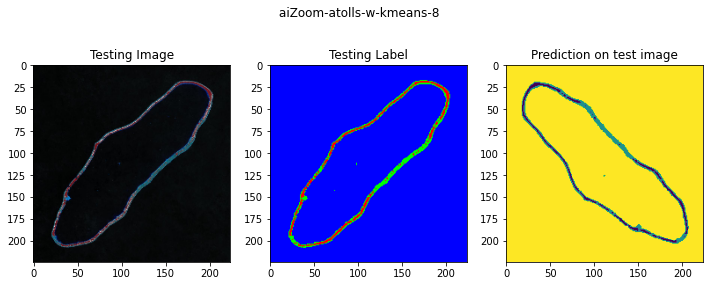

1/1 [==============================] - 0s 27ms/step


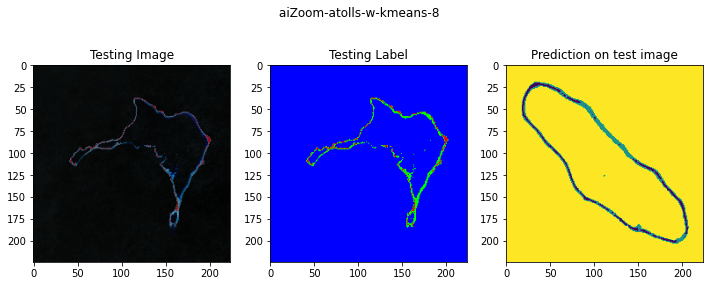

1/1 [==============================] - 0s 33ms/step


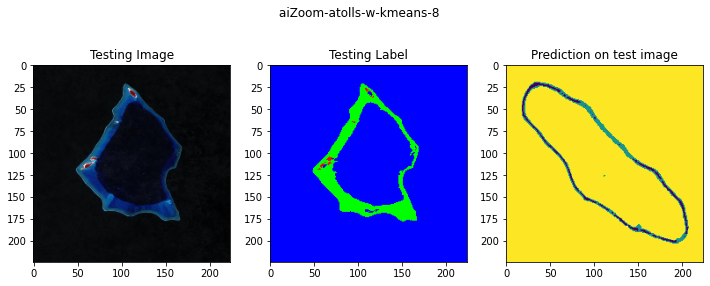

1/1 [==============================] - 0s 26ms/step


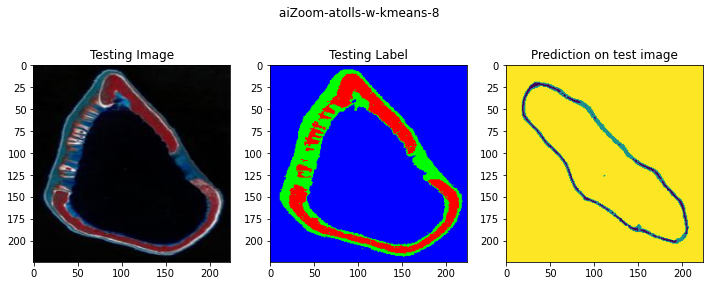

1/1 [==============================] - 0s 23ms/step


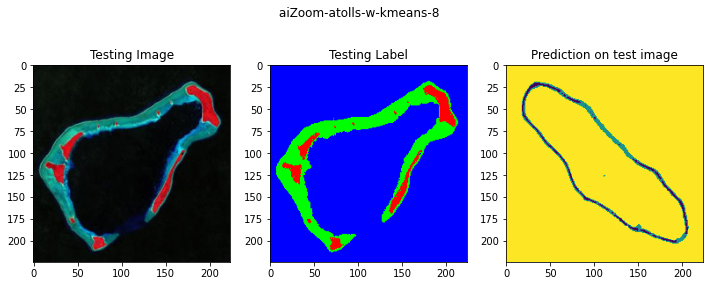

1/1 [==============================] - 0s 26ms/step


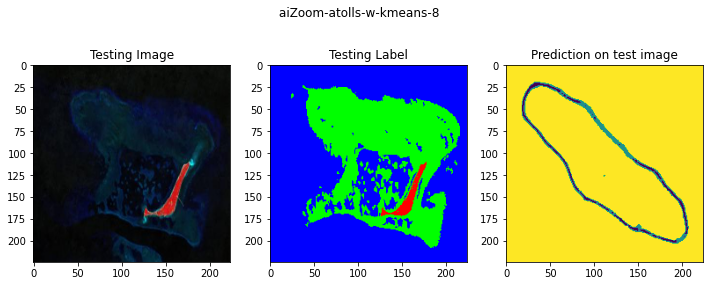

1/1 [==============================] - 0s 31ms/step


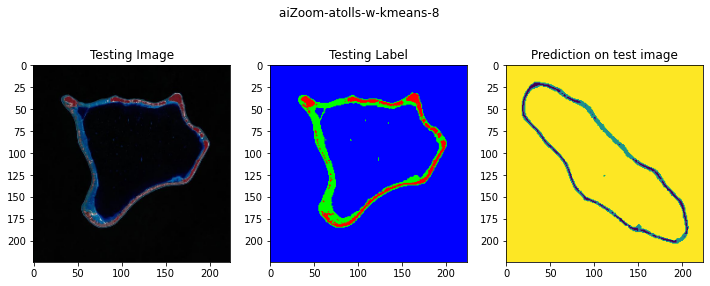

1/1 [==============================] - 0s 99ms/step


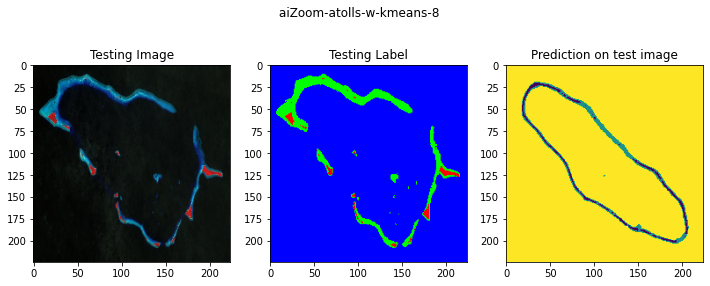

1/1 [==============================] - 0s 28ms/step


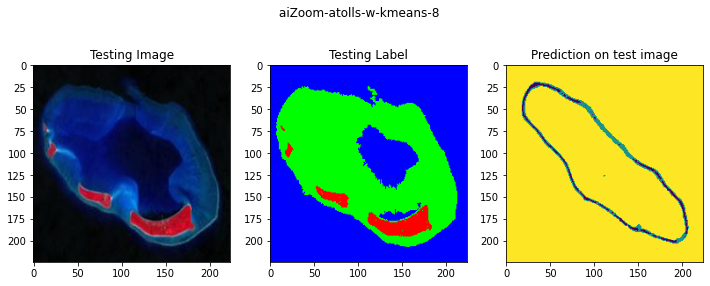

1/1 [==============================] - 0s 31ms/step


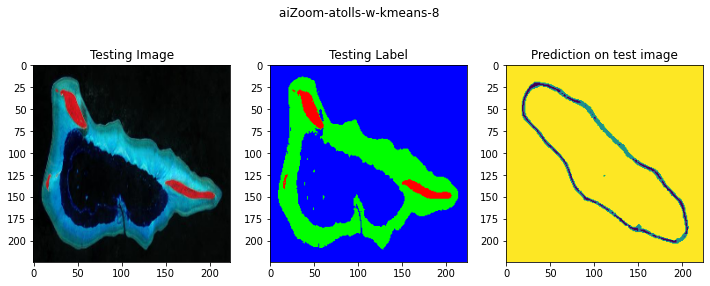

1/1 [==============================] - 0s 23ms/step


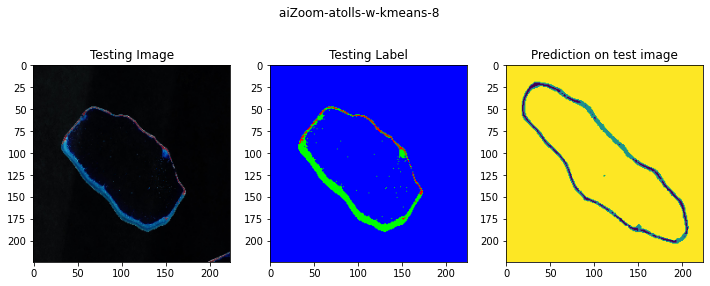

1/1 [==============================] - 0s 27ms/step


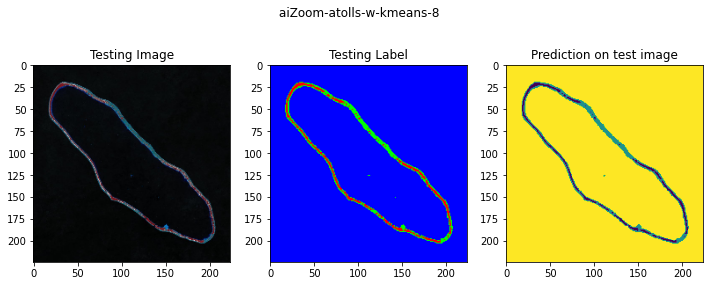

In [ ]:
for i in range(X_test.shape[0]):
  #iterate though our images and thier masks
  test_img = X_test[i]
  ground_truth=y_test[i]
  #make prediction
  prediction = (model.predict(four_dim))
  #prediction output is three continuous vals so take highest val for each coordinate (argmax)
  predicted_img=np.argmax(prediction, axis=3)[0,:,:]

  #define figure
  plt.figure(figsize=(12, 8))
  plt.subplot(231)
  #plot image
  plt.title('Testing Image')
  plt.imshow(test_img.astype(np.uint8), cmap='viridis')
  plt.subplot(232)
  #plot label
  plt.title('Testing Label')
  plt.imshow((255*ground_truth).astype(np.uint8), cmap='viridis')
  plt.subplot(233)
  #plot prediction
  plt.title('Prediction on test image')
  plt.imshow(predicted_img.astype(np.uint8), cmap='viridis')
  #figure title
  plt.suptitle(" aiZoom-atolls-w-kmeans-8")
  # #uncomment to save figures to folder
  ##save figure object to variable
  # fig = plt.gcf()
  # num = random.randint(0,100)
  # plt.savefig("/content/drive/MyDrive/AiZoom/savedFigs/aiZoom-atolls-w-kmeans-8-"+str(num))
  ##show figure in output
  plt.show()

## Step 6: Experimentation

Here's some information about our model performance

For this particular model: 50 epochs with a batch size of 4 produced the best results, however the results produced with epochs between 35 and 200 are of similar quality.  Overfitting doesn't seem to be a problem within that range.

**Model Performance:**


| Model | F1 | Mean IoU | Vegetation IoU | Reef IoU| Ocean IoU|
|:------|----------|----------|---------|-----------|---------:|
|u-net-k-means-8     | 0.856        |  0.940 | 0.926 | 0.921|0.974   |
|u-net-doodler-2       |  0.775  |     0.918     |   0.828       |0.924| 0.98
|segformer-doodler-2       |   N/A       |     0.853     |      0.835    |0.764| 0.962|


Above we can see that the model using doodler labels was slightly stronger in reef and ocean classification but so weak in the vegetation classification that the mean was much worse than the model using kmeans data. This causes a decrease in the F1 where the kmeans model outperforms the doodler model 0.856 to 0.775.  This is significant.

Additionally, we can see that the segformer based transfer learning model is slightly weaker than our k-means and doodler models in every metric.  

## Step 7: Our observations from the results

Note: If you have done interrater agreement, energy usage, size, speed analysis, feel free to mention it here.


**Model Speed and Size**

| Model | size (MB) | CPU time (μs) |
|:------|----------|----------:|
|u-net-k-means-8     | 22      |  1.5 |
|u-net-doodler-2       |  22        |    3     |   
|segformer-doodler-2       |   14       |     2     |  


Overall, it is very clear that u-net implemented using the kmeans labeled dataset is our most effective model, but the one using doodler labeling is also strong.

## Step 8: Future work plan for improvement

1. Relabel data using kmeans clustering for 4-5 classes, adding a class distinguishing sand and shallow ocean from reef flat

2. Collect more data and utilize more methods of data augmentation.

3. Try additional model archictectures which are popular in semantic segmentation of satellite and aerial images such as a fully connected network.

4. explore applying transfer learning from models such as segformer or ResNet FCN (Fully Convolutional Network)
